In [1]:
from qiskit import IBMQ
import warnings
import sys
sys.path.insert(1, 'Scripts')
#warnings.filterwarnings('ignore')

# Load Account and Choose Backend
# IBMQ.load_account()
# provider = IBMQ.get_provider('ibm-q')
# name = 'ibmq_belem'
# backend = provider.get_backend(name)

In [2]:
# Own Functions
from qiskit import QuantumCircuit, transpile, execute
from qiskit.tools.monitor import job_monitor

# Numerical/Stats pack
import csv
import pandas as pd
import numpy as np
import scipy.stats as ss
import numpy.linalg as nl

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# For optimization
from cvxopt import matrix, solvers


file_address = 'BelemData/'
shots = 8192

In [3]:
def param_record(backend, itr=32, shots=8192, if_write=True, file_address=''):
    """Write backend property into an array of dict 
       and save as csv if permissible.

    Args:
      backend: IBMQBackend
        backend from provider.get_backend().
      itr: int
        number of iterations of job submission.
      shots: int
        number of shots per each job submission.
      if_write: boolean
        True if save the properties as a csv file.
      file_address: string
        The relative file address to save backend properties. 
        Ends with '/' if not empty
        The default is ''.

    Returns: numpy array
      An array of dicts. Each dict records all characterization of one qubit.
    """
    prop_dict = backend.properties().to_dict()
    nQubits = len(prop_dict['qubits'])
    backend_name = prop_dict['backend_name']

    target_qubits = range(nQubits)
    allParam = np.array([])
    for target_qubit in target_qubits:
        params = {
            'qubit':
            target_qubit,
            'update_date':
            prop_dict['last_update_date'],
            'T1':
            prop_dict['qubits'][target_qubit][0]['value'],
            'T2':
            prop_dict['qubits'][target_qubit][1]['value'],
            'freq':
            prop_dict['qubits'][target_qubit][2]['value'],
            'readout_err':
            prop_dict['qubits'][target_qubit][3]['value'],
            'pm0p1':
            prop_dict['qubits'][target_qubit][4]['value'],
            'pm1p0':
            prop_dict['qubits'][target_qubit][5]['value'],
            'id_error':
            prop_dict['gates'][4 * target_qubit]['parameters'][0]['value'],
            'id_len':
            prop_dict['gates'][4 * target_qubit]['parameters'][1]['value'],
            'u1_error':
            prop_dict['gates'][4 * target_qubit + 1]['parameters'][0]['value'],
            'u1_len':
            prop_dict['gates'][4 * target_qubit + 1]['parameters'][1]['value'],
            'u2_error':
            prop_dict['gates'][4 * target_qubit + 2]['parameters'][0]['value'],
            'u2_len':
            prop_dict['gates'][4 * target_qubit + 2]['parameters'][1]['value'],
            'u3_error':
            prop_dict['gates'][4 * target_qubit + 3]['parameters'][0]['value'],
            'u3_len':
            prop_dict['gates'][4 * target_qubit + 3]['parameters'][1]['value'],
            'itr':
            itr,
            'shots':
            shots,
        }
        allParam = np.append(allParam, params)

    if if_write:
        with open(file_address + 'Params.csv', mode='w', newline='') as sgm:
            param_writer = csv.writer(sgm,
                                      delimiter=',',
                                      quotechar='"',
                                      quoting=csv.QUOTE_MINIMAL)
            for pa in allParam:
                for key, val in pa.items():
                    param_writer.writerow([key, val])
                param_writer.writerow(['End'])

    return allParam

In [4]:
# Record Device Parameters
# param_record(backend, itr=64, shots=shots, if_write=True, file_address=file_address)

In [5]:
num_qubits = 5
num_repeat = 2

# circs = []
# for bn in range(2**num_qubits):
#     target = format(bn, "0{:d}b".format(num_qubits))
#     circ_mean = QuantumCircuit(num_qubits, num_qubits, name=target)
#     for i in range(num_qubits):
#         if target[i] == '1':
#             circ_mean.x(num_qubits-1-i)  # follow measurement order
#     circ_mean.measure(range(num_qubits), range(num_qubits))
#     circ_mean_trans = transpile(circ_mean, backend, initial_layout=range(num_qubits))
#     circ_mean_trans .draw(output='mpl',filename=file_address+target+"circ.jpg")
#     for i in range(num_repeat):
#         circs.append(circ_mean_trans.copy(target+"-{:d}" .format(i)))

In [6]:
# job_m0 = execute(circs, backend=backend, shots=shots, memory=True, optimization_level=0)
# job_monitor(job_m0)

In [7]:
# job_m1 = execute(circs, backend=backend, shots=shots, memory=True, optimization_level=0)
# job_monitor(job_m1)

In [8]:
# job_m2 = execute(circs, backend=backend, shots=shots, memory=True, optimization_level=0)
# job_monitor(job_m2)

In [9]:
# job_m3 = execute(circs, backend=backend, shots=shots, memory=True, optimization_level=0)
# job_monitor(job_m3)

In [10]:
# # Save bits
# for bn in range(2**num_qubits):
#     target = format(bn, "0{:d}b".format(num_qubits))
#     readout_basis = np.array([])
#     for job in [job_m0, job_m1, job_m2, job_m3]:
#         res_basis = job.result()
#         for i in range(num_repeat):
#             readout_basis = np.append(readout_basis, res_basis.get_memory(experiment=(target+"-{:d}" .format(i))))
        
#     # Save
#     np.savetxt(file_address + 'Basis'+target+'.csv', readout_basis, delimiter=',', fmt='%s')

# Check Matrix

In [11]:
def dictToVec(nQubits, counts):
    """ Transfer counts to probabilities

    Args:
      nQUbits: int
        number of qubits
      counts: dict
        an dictionary in the form {basis string: frequency}. E.g.
        {"01": 100
         "11": 100}
        dict key follow little-endian convention

    Returns: numpy array
      an probability vector (array). E.g.
      [0, 0.5, 0, 0.5] is the result from example above.
    """
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec

In [12]:
# Read Bits
from collections import Counter
mean_mat = np.zeros((2**num_qubits,2**num_qubits))
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
    mean_mat[:,int(target,2)] = dictToVec(num_qubits,dict(Counter(string_data)))/(shots*num_repeat*4)
    
mean_mat,mean_mat.sum(axis=0)

(array([[9.40200806e-01, 6.11419678e-02, 5.77392578e-02, ...,
         0.00000000e+00, 1.52587891e-05, 0.00000000e+00],
        [2.53143311e-02, 9.11972046e-01, 1.41906738e-03, ...,
         9.15527344e-05, 0.00000000e+00, 0.00000000e+00],
        [1.17492676e-02, 5.64575195e-04, 8.97338867e-01, ...,
         0.00000000e+00, 7.62939453e-05, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.04290771e-01, 1.22070312e-03, 4.80346680e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.05175781e-04, 7.92083740e-01, 5.24902344e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.89697266e-03, 2.18963623e-02, 7.63504028e-01]]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [13]:
np.set_printoptions(suppress=True, threshold=sys.maxsize)
print(mean_mat)

[[0.94020081 0.06114197 0.05773926 0.00331116 0.04962158 0.00344849
  0.00280762 0.00021362 0.04519653 0.00291443 0.00236511 0.00019836
  0.00245667 0.00016785 0.00010681 0.         0.03807068 0.00250244
  0.00202942 0.00022888 0.00204468 0.00016785 0.00010681 0.
  0.00187683 0.00010681 0.00010681 0.         0.00004578 0.
  0.00001526 0.        ]
 [0.02531433 0.91197205 0.00141907 0.05601501 0.00123596 0.0483551
  0.00010681 0.00262451 0.00152588 0.04475403 0.00007629 0.00254822
  0.00006104 0.00218201 0.00001526 0.00009155 0.00100708 0.03692627
  0.00007629 0.00212097 0.00012207 0.00189209 0.         0.00013733
  0.00004578 0.00154114 0.         0.00015259 0.         0.00009155
  0.         0.        ]
 [0.01174927 0.00056458 0.89733887 0.05831909 0.00053406 0.00004578
  0.04652405 0.00286865 0.00082397 0.00003052 0.04229736 0.00325012
  0.00001526 0.00001526 0.00231934 0.00016785 0.00064087 0.00001526
  0.03747559 0.00205994 0.00001526 0.         0.00205994 0.00012207
  0.00003052 0.

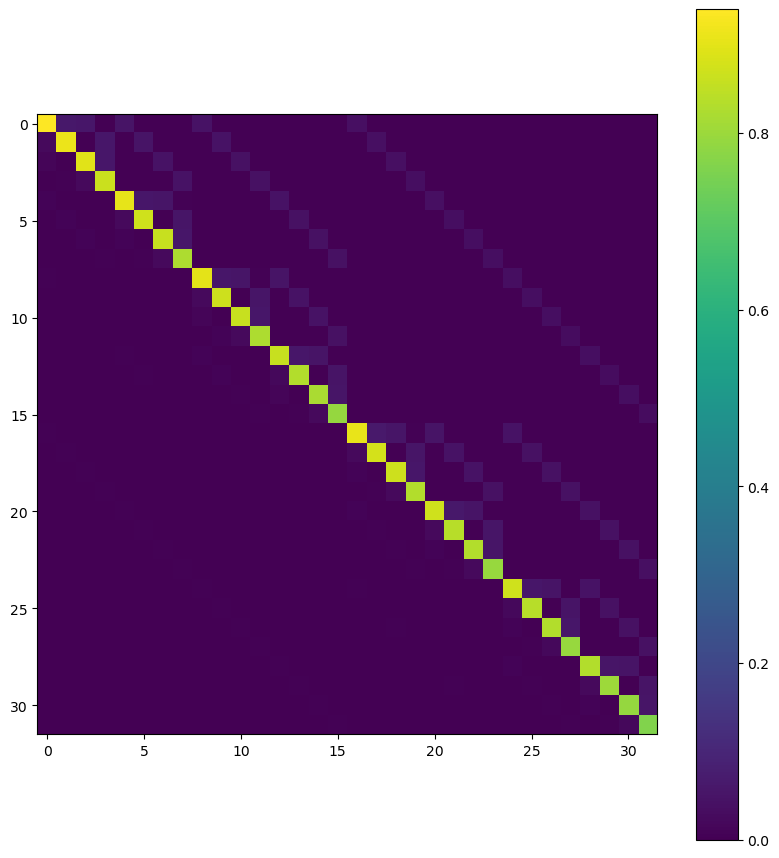

In [14]:
plt.rcParams["figure.figsize"] = (10, 11)
plt.rcParams["figure.dpi"] = 100

plt.imshow(mean_mat)
plt.colorbar()
plt.show()

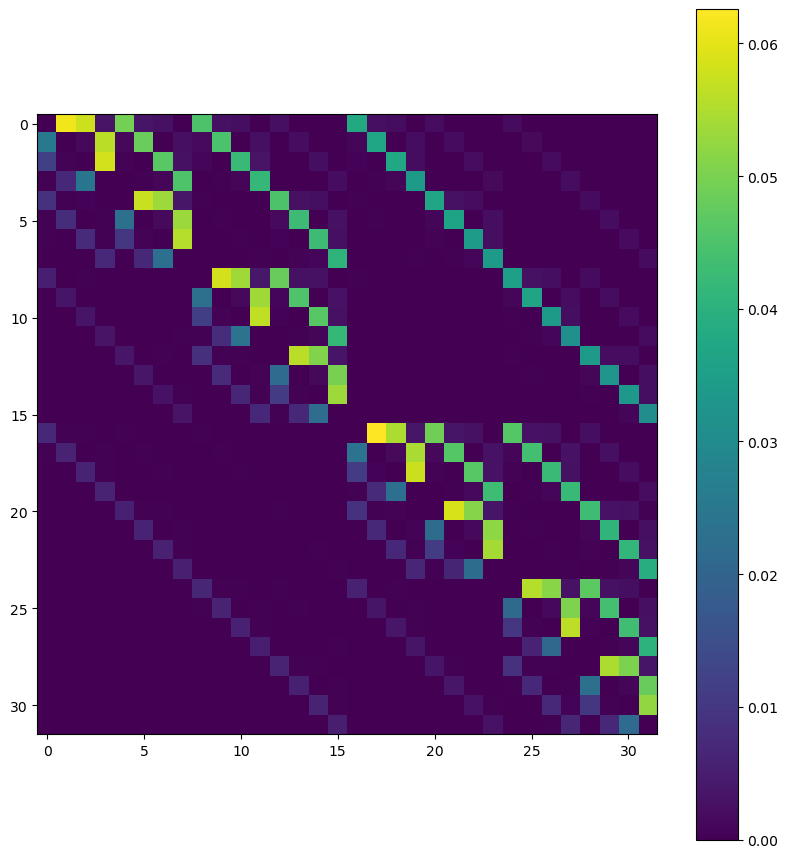

In [15]:
# Zero out diagonal
# Note that prob_meas0_prep1 is usually the dominant factor in the readout error due to relaxation during the measurement process. 
zero_diag = np.copy(mean_mat)
for i in range(2**num_qubits):
    zero_diag[i,i] = 0

plt.imshow(zero_diag)
plt.colorbar()
plt.show()

# Hadamard

In [16]:
# circ_had = QuantumCircuit(num_qubits, num_qubits, name=target)
# for i in range(num_qubits):
#     circ_had.h(i)
# circ_had.measure(range(num_qubits), range(num_qubits))
# circ_had_trans = transpile(circ_had, backend, initial_layout=range(num_qubits))
# circ_had_trans.draw(output='mpl',filename=file_address+"had_circ.jpg")

# had_circs = []
# for i in range(64):
#     had_circs.append(circ_had_trans.copy("had-{:d}".format(i)))

In [17]:
# job_had = execute(had_circs, backend=backend, shots=shots, memory=True, optimization_level=0)
# job_monitor(job_had)

In [18]:
# # Save bits
# res_had = job_had.result()
# readout_had = np.array([])
# for bn in range(64):
#     readout_had = np.append(readout_had, res_had.get_memory(experiment=("had-{:d}".format(bn))))

# # Save
# np.savetxt(file_address + 'Had.csv', readout_had, delimiter=',',fmt='%s')

Ideal prob = 0.03125


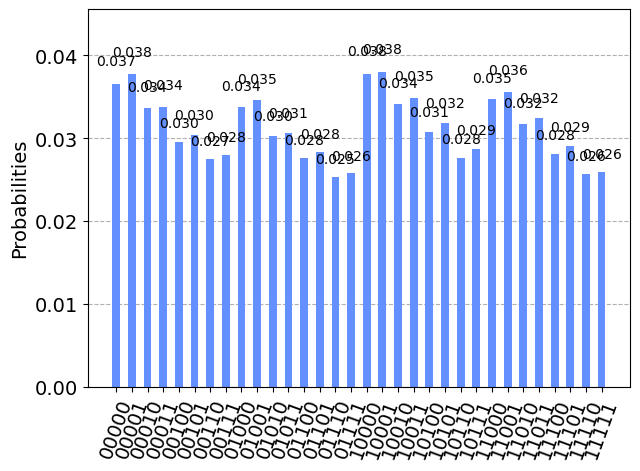

In [19]:
# Read bits
had_strings = np.genfromtxt(file_address + 'Had.csv', delimiter=',',dtype=np.str)

print("Ideal prob = {:}".format(1/2**num_qubits))
from qiskit.visualization import plot_histogram
plot_histogram(Counter(had_strings))

In [20]:
num_group = 8
had_groups = np.split(had_strings, num_group)
had_probs = np.zeros((2**num_qubits,num_group))
for i in range(num_group):
    for d in had_groups[i]:
        had_probs[int(d,2),i] += 1

had_probs = had_probs/had_probs.sum(axis=0)

# plt.figure(figsize=(20,6)) 
# plt.plot(had_probs[0], label='Pr('+'0'*num_qubits+'|'+'0'*num_qubits+')')
# plt.plot(had_probs[2**num_qubits-1], label='Pr('+'1'*num_qubits+'|'+'1'*num_qubits+')')
# plt.title("Outcomes from hadamard circuits")
# plt.legend()
# plt.show()

# print(np.mean(had_probs[0]), np.mean(had_probs[2**num_qubits-1]))

In [21]:
def read_filter_data(file_address=''):
    cali_data = {}
    for bn in range(2**num_qubits):
        target = format(bn, "0{:d}b".format(num_qubits))
        cali_data[target]=np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
    return cali_data
def getData0(data, num_group, num_qubits):
    # Split bit string data
    groups = np.split(data, num_group)
    
    probs = np.zeros((2**num_qubits, num_group))
    for i in range(num_group):
        for d in groups[i]:
            probs[int(d,2),i] += 1
    
    # Normalize
    probs = probs/probs.sum(axis=0)
    return probs

In [22]:
# Read test circuit data
cali = read_filter_data(file_address=file_address)
cali_probs = {}
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    cali_probs[target] = getData0(cali[target], num_group, num_qubits)

In [23]:
cali_all0 = 0
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    cali_all0 += cali_probs[target][0]
    
cali_all1 = 0
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    cali_all1 += cali_probs[target][2**num_qubits - 1] 

Basis
0.03809976577758789 0.025265216827392578
Hadamard
0.03658103942871094 0.025964736938476562


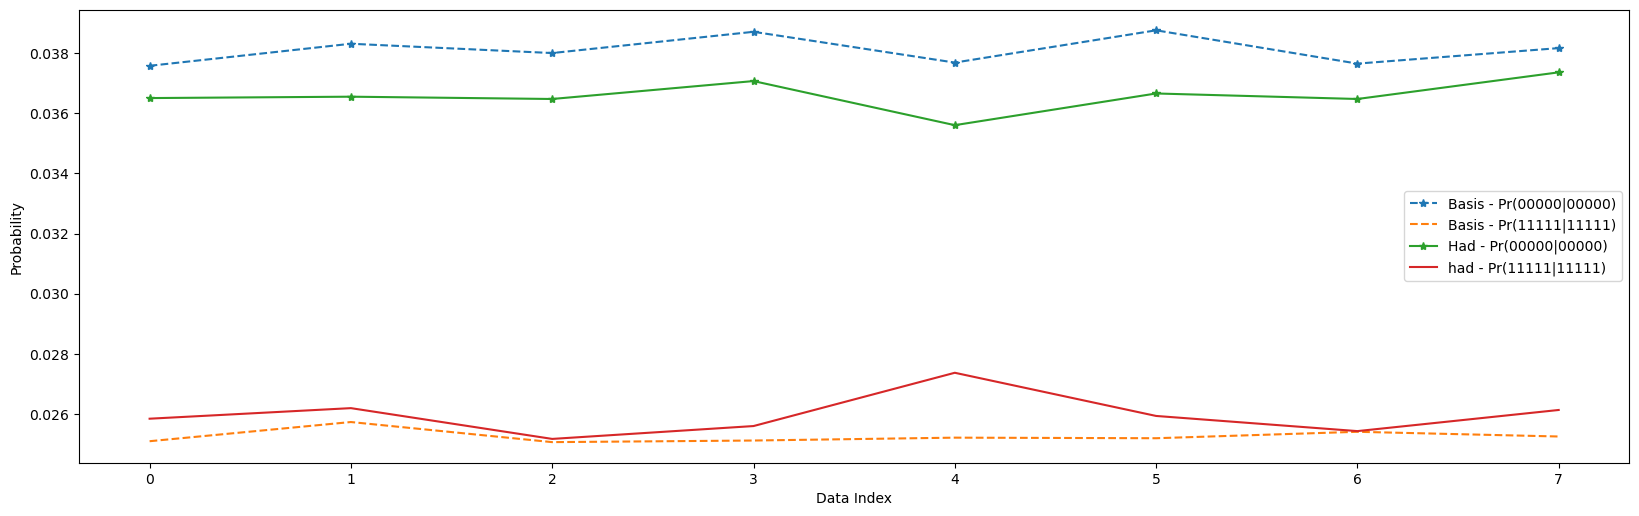

In [24]:
print("Basis")
print(np.mean(cali_all0/2**num_qubits), np.mean(cali_all1/2**num_qubits))
print("Hadamard")
print(np.mean(had_probs[0]), np.mean(had_probs[2**num_qubits-1]))

plt.figure(figsize=(20,6)) 
plt.plot(cali_all0/2**num_qubits, marker = '*', linestyle = '--', label='Basis - Pr('+'0'*num_qubits+'|'+'0'*num_qubits+')')
plt.plot(cali_all1/2**num_qubits, linestyle = '--', label='Basis - Pr('+'1'*num_qubits+'|'+'1'*num_qubits+')')
plt.plot(had_probs[0], marker = '*', label='Had - Pr('+'0'*num_qubits+'|'+'0'*num_qubits+')')
plt.plot(had_probs[2**num_qubits-1], label='had - Pr('+'1'*num_qubits+'|'+'1'*num_qubits+')')
plt.xlabel("Data Index")
plt.ylabel("Probability")
plt.legend()
plt.show()

# Ind Filter

In [25]:
# job_ind = execute(had_circs, backend=backend, shots=shots, memory=True, optimization_level=0)
# job_monitor(job_ind)

In [26]:
# # Save bits
# res_ind = job_ind.result()
# readout_ind = np.array([])
# for bn in range(64):
#     readout_ind = np.append(readout_ind, res_ind.get_memory(experiment=("had-{:d}".format(bn))))

# with open(file_address + 'Filter_data.csv', mode='w') as sgr:
#     read_writer = csv.writer(sgr,
#                              delimiter=',',
#                              quotechar='"',
#                              quoting=csv.QUOTE_MINIMAL)
#     read_writer.writerow(readout_ind)

Qubit 4
Given Lambdas [0.9334 0.9567]


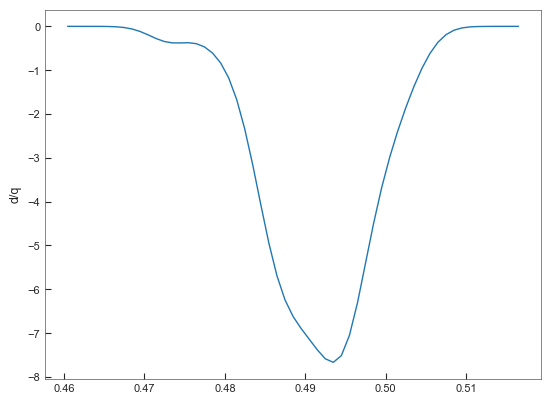

(0.46046046046046046, 0.5165165165165165)
Final Accepted Posterior Lambdas
M: 7.66732 Maximizer: 0.493415 pi_obs = 63.5283 pi_Q(prior) = 8.2856
Progress: 99.997%
Accepted Number N: 5263, fraction 0.132
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.90585667 0.92260453]
Posterior Lambda Mode [0.92908989 0.94989722]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00160784
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


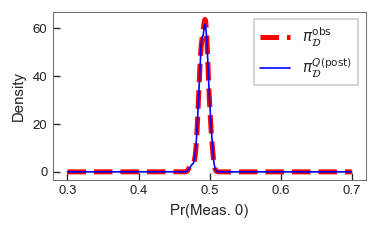

Qubit 3
Given Lambdas [0.9662 0.979 ]


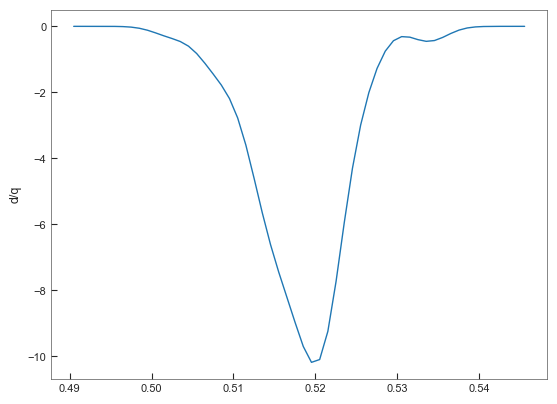

(0.4904904904904905, 0.5455455455455456)
Final Accepted Posterior Lambdas
M: 10.2415 Maximizer: 0.519913 pi_obs = 80.2454 pi_Q(prior) = 7.83531
Progress: 99.997%
Accepted Number N: 3875, fraction 0.097
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94110982 0.90459228]
Posterior Lambda Mode [0.97922826 0.93576433]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00348809
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


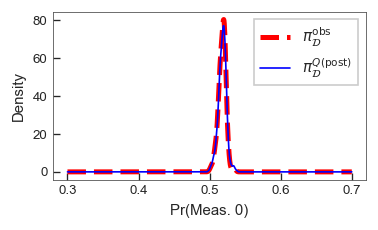

Qubit 2
Given Lambdas [0.9614 0.9768]


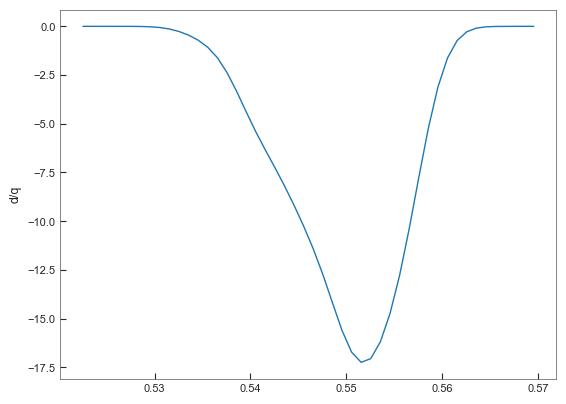

(0.5225225225225225, 0.5695695695695696)
Final Accepted Posterior Lambdas
M: 17.2698 Maximizer: 0.551785 pi_obs = 67.9189 pi_Q(prior) = 3.93282
Progress: 99.997%
Accepted Number N: 2300, fraction 0.058
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94874944 0.85125732]
Posterior Lambda Mode [0.9851613 0.874101 ]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00496372
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


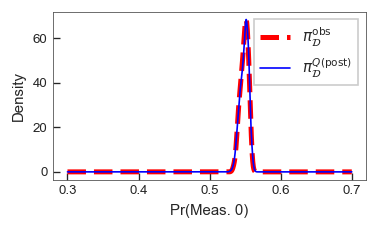

Qubit 1
Given Lambdas [0.9642 0.9789]


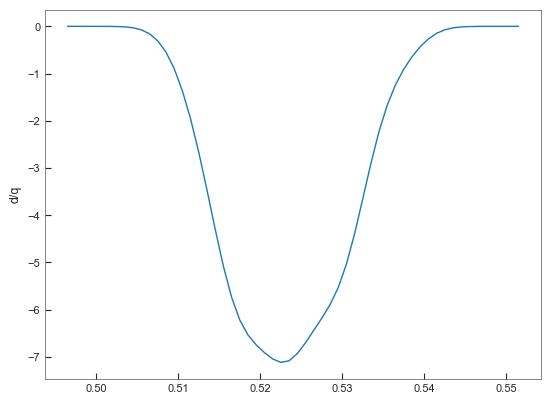

(0.4964964964964965, 0.5515515515515516)
Final Accepted Posterior Lambdas
M: 7.12042 Maximizer: 0.522762 pi_obs = 53.3115 pi_Q(prior) = 7.48713
Progress: 99.997%
Accepted Number N: 5574, fraction 0.139
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94184785 0.89681664]
Posterior Lambda Mode [0.97761016 0.92431306]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00167355
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


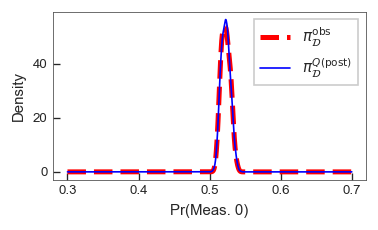

Qubit 0
Given Lambdas [0.9234 0.9491]


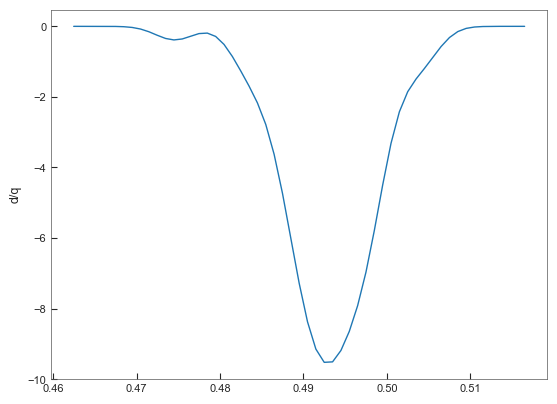

(0.4624624624624625, 0.5165165165165165)
Final Accepted Posterior Lambdas
M: 9.5633 Maximizer: 0.492946 pi_obs = 76.6194 pi_Q(prior) = 8.01182
Progress: 99.997%
Accepted Number N: 4240, fraction 0.106
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.90288973 0.9167052 ]
Posterior Lambda Mode [0.92657715 0.9447191 ]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.0033295
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


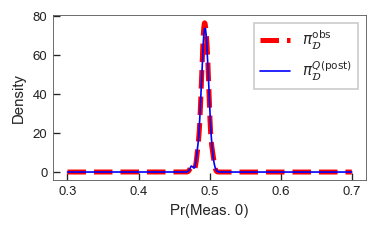

In [27]:
import measfilter as mf
ind_filter = mf.MeasFilter([4, 3, 2, 1,0], file_address=file_address)
ind_filter.inference(seed=14687,show_denoised=False,shots_per_point=8192)

In [28]:
ind_filter.mean()

{'Qubit4': array([0.90585667, 0.92260453]),
 'Qubit3': array([0.94110982, 0.90459228]),
 'Qubit2': array([0.94874944, 0.85125732]),
 'Qubit1': array([0.94184785, 0.89681664]),
 'Qubit0': array([0.90288973, 0.9167052 ])}

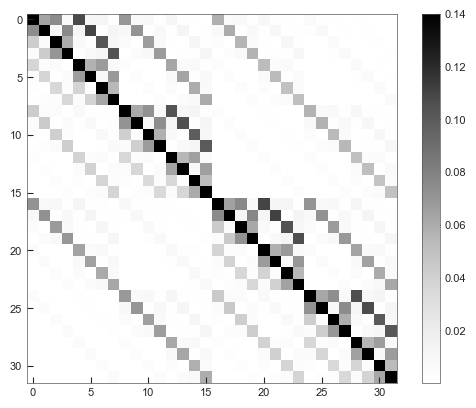

In [36]:
# Zero out diagonal
# Note that prob_meas0_prep1 is usually the dominant factor in the readout error due to relaxation during the measurement process. 
ind_zero_diag = np.copy(ind_filter.mat_mean)
for i in range(2**num_qubits):
    ind_zero_diag[i,i] = 0.14

plt.imshow(ind_zero_diag)
plt.colorbar()
plt.show()

# Hadamard Error Filtering

In [30]:
def find_least_norm(nQubits, ptilde):
    # Formulation
    Q = 2 * matrix(np.identity(2**nQubits))
    p = -2 * matrix(ptilde)

    G = -matrix(np.identity(2**nQubits))
    h = matrix(np.zeros(2**nQubits))

    A = matrix(np.ones(2**nQubits), (1, 2**nQubits))
    b = matrix(1.0)

    solvers.options['show_progress'] = False
    sol = solvers.qp(Q, p, G, h, A, b)
    return sol['status'], sol['x']


def dictToVec(nQubits, counts):
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec


def vecToDict(nQubits, shots, vec):
    counts = {}
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i)
        counts[key] = int(vec[i] * shots)
    return counts

def meas_dist(true_probs, real_counts):
    total_counts = sum(real_counts.values())
    counts_off = 0
    for key in real_counts:
        counts_off += np.abs(real_counts[key] - true_probs[int(key,2)]*total_counts)
        
    return counts_off/total_counts

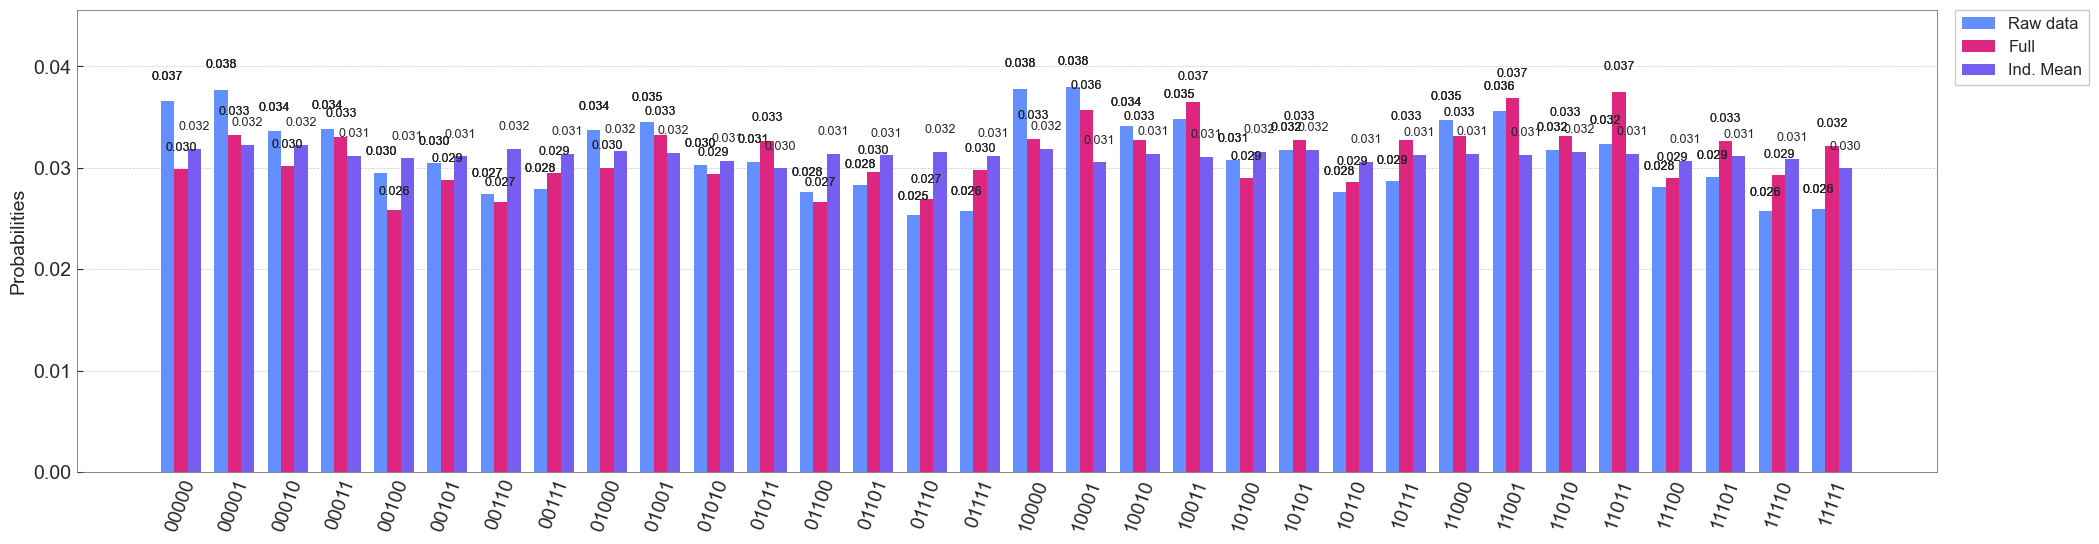

In [31]:
real_counts = Counter(had_strings)
real_vec = dictToVec(num_qubits,real_counts)/(shots*64)
full_status, full_vec = find_least_norm(num_qubits, nl.solve(mean_mat, real_vec))
full_counts = vecToDict(num_qubits, shots*64, full_vec)
ind_counts = ind_filter.filter_mean(real_counts)

legend = ["Raw data", "Full",  "Ind. Mean"]
plot_histogram([real_counts, full_counts, ind_counts], legend=legend,  figsize=(24, 6))

In [32]:
had_probs = [1/2**num_qubits]*(2**num_qubits)
print("Raw: total probalities dist from true = {:.4f}".format(meas_dist(had_probs, real_counts)))
print("Full A: total probalities dist from true = {:.4f}".format(meas_dist(had_probs, full_counts)))
print("Ind. Mean: total probalities dist from true = {:.4f}".format(meas_dist(had_probs, ind_counts)))

Raw: total probalities dist from true = 0.1044
Full A: total probalities dist from true = 0.0821
Ind. Mean: total probalities dist from true = 0.0127
